# Add arbitrary Stan code to an HBOMS model

One goal of HBOMS is to produce human-readable Stan models that can be further developed and customized by the user. However, modifying an HBOMS-generated model makes it hard to change the basic parameter structure, as the modifications would have to be re-applied after each change. Therefore, the user can also include "plugin" Stan code in the HBOMS model definition. This plugin code is added as-is at the end of the code blocks (or beginning for the `functions` block). 

To use this functionality, the user must provide a Python dictionary with keys equal to the names of the code blocks. For example

```python
plugin_code = {
    "data" : "real SomeDataPoint;",
    "model" : "SomeDataPoint ~ exponential(lambda);"
}
```

will add the declaration for `SomeDataPoint` to the `data` block, and a "sampling statement" to the model block. This sampling statement uses a parameter `lambda` and so it is important that this is defined in the HBOMS model.

The `plugin_code` dictionary is then passed as a keyword argument in the `HbomsModel` initiation

```python
model = hboms.HbomsModel(
    name = "my_model",
    # other arguments...
    plugin_code = plugin_code
)
```


## Example: SEIR model with serial interval data

As an example, we look at an epidemiological model of an infectious disease in which we have time series data, but also additional observations in the form of observed serial intervals (the time between symptom onset of a primary and secondary patient). The epidemiological model will be the SEIR model (susceptible, exposed, infected, recovered), and we will pretend that the serial interval is the same as the generation interval (the time between infections). 

The ODEs for the SEIR model are given by 

\begin{equation}
\begin{split}
\frac{dS}{dt} &= -\beta SI \\
\frac{dE}{dt} &= \beta SI - \alpha E \\
\frac{dI}{dt} &= \alpha E - \gamma I
\end{split}
\end{equation}

and initial condition $S(0) = 1-\epsilon$, $E(0) = 0$, $I(0) = \epsilon$.
We'll assument that the observed data at time `t` follows a Poisson distribution with mean `SampleSize * I(t)`.
Let's start with creating the nessecary ingredients of an HBOMS model.

In [11]:
import hboms

params = [
    hboms.Parameter("beta", 1.0, "random", scale=0.1), 
    hboms.Parameter("alpha", 1.0, "random", scale=0.1),
    hboms.Parameter("gamma", 0.5, "random", scale=0.1),
    hboms.Parameter("SampleSize", 1e2, "const")
]

init = """
S_0 = 0.998;
E_0 = 0.0;
I_0 = 0.002; // we're lazy and use a hard-coded epsilon
"""

odes = """
ddt_S = -beta * S * I;
ddt_E = beta * S * I - alpha * E;
ddt_I = alpha * E - gamma * I;
"""

state = [hboms.Variable("S"), hboms.Variable("E"), hboms.Variable("I")]
obs = [hboms.Observation("Counts", data_type="int")]
dists = [hboms.StanDist("poisson", "Counts", ["I * SampleSize"])]

As additional data, we have a number of observed generation intervals $T_G$ which in the SEIR model are hypoexponentially distributed with rate parameters $\alpha$ and $\beta$. A hypoexponential random variable is the sum of two exponentially distributed random variables. Hence it is like the Erlang distribution, but the rates can differ between the summands.
In e.g. [Roberts and Heesterbeek](https://doi.org/10.1007/s00285-007-0112-8), we find an explicit formula for the PDF

$$ f(t) = \frac{\alpha\gamma}{\gamma-\alpha} (e^{-\alpha t} - e^{-\gamma t}) $$

This equation is a bit annoying for estimating $\alpha$ and $\gamma$, though, because it has a removable singularity at $\alpha = \gamma$. Therefore, we use a somewhat less explicit, but equivalent, equation

$$ f(t) = -(1,0) \exp(\Theta t) \Theta (1,1)'\quad \mbox{where}\quad \Theta = \left(\begin{array}{cc}-\alpha & \alpha \\ 0 &-\gamma \end{array}\right) $$
and $\exp$ is the matrix exponential and we trust that the implementation of the matrix exponential in Stan is efficient and accurate.

To implement this, we will add some plugin code to the `functions`, `data` and `model` blocks.
We define the `hypoexp` distribution in the `functions` block, declare a data array (and it's size) in the `data` block and write a "sampling statement" for the `model` block. For defining the data array, we can make use of the variable `R` which is the number of units.
For the sampling statements, we'll make use of the parameters $\alpha$ and $\gamma$.

:::{caution}
As these are random parameters, we will have to index them. If you were to change $\alpha$ or $\gamma$ to fixed parameters, you would have to make sure the indexing is removed in the plugin code.
:::

With this plugin code in place, we finally initiate the HBOMS model.

In [2]:
plugin_code_functions = """
real hypoexp_lpdf(real t, real a, real b) {
    matrix[2, 2] Theta = [[-a, a], [0,-b]];
    return log(sum((-matrix_exp(Theta .* t) * Theta)[1,:]));
}
"""

plugin_code_data = """
int NumIntervalSamples;
array[R, NumIntervalSamples] real IntervalSamples;
"""

plugin_code_model = """
for ( r in 1:R ) {
    for ( n in 1:NumIntervalSamples ) {
        IntervalSamples[r,n] ~ hypoexp(alpha[r], gamma[r]);
    }
}
"""

plugin_code = {
    "functions" : plugin_code_functions,
    "data" : plugin_code_data,
    "model" : plugin_code_model
}

model = hboms.HbomsModel(
    "plugin_model",
    state,
    odes,
    init,
    params,
    obs,
    dists,
    plugin_code=plugin_code
)

Using the `show_stan_model` utility, we can have a look at what HBOMS has generated.
Notice that the plugin function is defined before the other functions. The motivation is that we might want to define functions that are used in the ODE model definition. The other plugin code is added at the end of the code blocks.

In [3]:
hboms.utilities.show_stan_model(model.model_code)

## Simulate data with the Stan model

Next, we use the Stan model to simulate some data. We have to provide time points for each unit at which we want to generate pseudo-observations.

In [4]:
import numpy as np

R = 6
Time = [np.linspace(1, 40, 40) for _ in range(R)]
data = {"Time" : Time}
sims = model.simulate(data=data, num_simulations=10)
# select the first simulated data set, and get the random parameters
sim_data, sim_pars = sims[0]

15:05:34 - cmdstanpy - INFO - CmdStan start processing
15:05:34 - cmdstanpy - INFO - Chain [1] start processing
15:05:34 - cmdstanpy - INFO - Chain [1] done processing


We will now add simulated generation intervals for each unit. We can simulate these using the sum of two exponentially distributed random deviates, using `scipy.stats`.

In [5]:
import scipy.stats as sts

alpha_gt = sim_pars["alpha"]
gamma_gt = sim_pars["gamma"]

NumIntervalSamples = 100
IntervalSamples = [
    sts.expon.rvs(scale=1/alpha, size=NumIntervalSamples) + \
    sts.expon.rvs(scale=1/gamma, size=NumIntervalSamples)
    for alpha, gamma in zip(alpha_gt, gamma_gt)
]

sim_data["NumIntervalSamples"] = NumIntervalSamples
sim_data["IntervalSamples"] = IntervalSamples

## Fit the Stan model to the simulated data

Next, we use the `sample` method to fit the model. At this point it is important that the additinal data has been added to the data dictionary `sim_data`, otherwise Stan will raise an exception, indicating that data is missing. This is also true if you use `init_check`.

In [6]:
model.sample(
    data=sim_data, 
    iter_warmup=200, iter_sampling=200, 
    refresh=1, 
    step_size=0.01, adapt_delta=0.95,
    threads_per_chain=R
)

15:05:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:09:01 - cmdstanpy - INFO - CmdStan done processing.
15:09:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (1.5%)
	Chain 2 had 1 divergent transitions (0.5%)
	Chain 4 had 5 divergent transitions (2.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


We then use `post_pred_check` to inspect the fitted model trajectories.

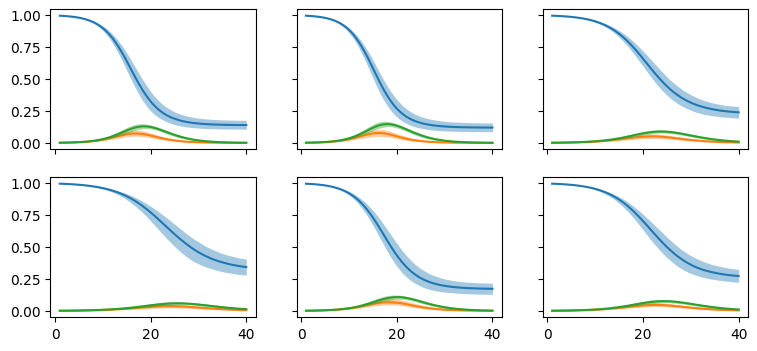

In [7]:
fig = model.post_pred_check(data=sim_data, obs_names=[])

And how the posterior predictive distributions mach with the data.

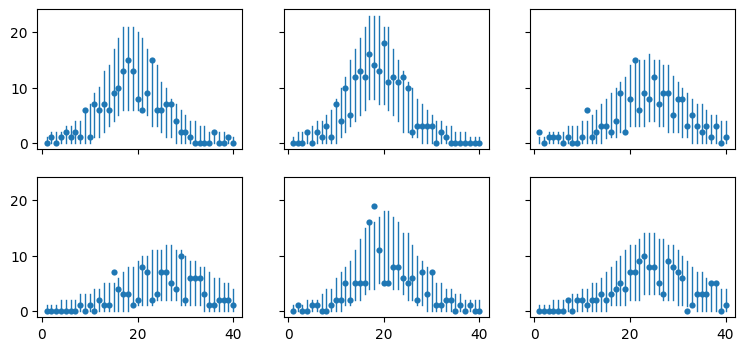

In [8]:
fig = model.post_pred_check(data=sim_data, state_var_names=[])

Even though we have a lot of data to infer parameter values from, the parameters show high posterior correlations.
We show this for $\beta$ and $\gamma$ below

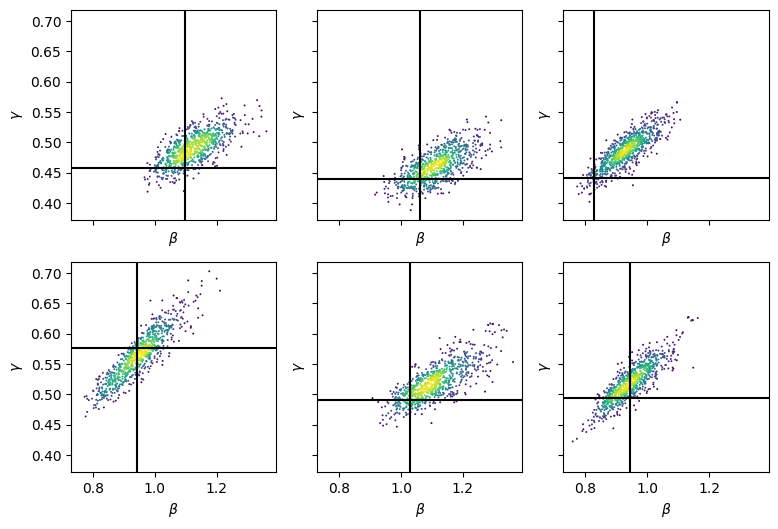

In [9]:
import matplotlib.pyplot as plt

def plot_beta_vs_gamma(model, gt_pars, nrows, ncols):
    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols,3*nrows), sharex=True, sharey=True)
    
    for i, ax in enumerate(axs.flat):
        beta = model.fit.stan_variable("beta")[:,i]
        gamma = model.fit.stan_variable("gamma")[:,i]
        z = sts.gaussian_kde(bg := np.stack([beta, gamma]))(bg)
        ax.scatter(beta, gamma, s=2, linewidths=0, c=z)
        ax.set(xlabel="$\\beta$", ylabel="$\\gamma$")
        beta_gt = gt_pars["beta"][i]
        gamma_gt = gt_pars["gamma"][i]
        ax.axhline(gamma_gt, color='k')
        ax.axvline(beta_gt, color='k')

    return fig, axs

fig, axs = plot_beta_vs_gamma(model, sim_pars, 2, 3)

Of course we can also estimate the basic reproduction number $R_0 = \beta / \gamma$. We can quite precisely estimate $R_0$, which would not be the case had we excluded the generation interval data.

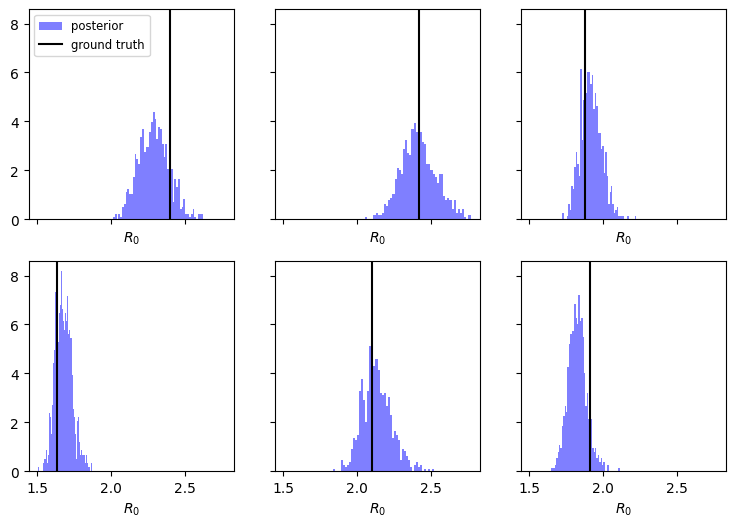

In [10]:
def plot_R0(model, gt_pars, nrows, ncols):
    R0 = model.fit.stan_variable("beta") / model.fit.stan_variable("gamma")
    R0_gt = gt_pars["beta"] / gt_pars["gamma"]

    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols,3*nrows), sharex=True, sharey=True)

    for i, ax in enumerate(axs.flat):
        ax.hist(R0[:,i], 50, density=True, color='b', alpha=0.5, label="posterior")
        ax.axvline(R0_gt[i], color='k', label="ground truth")
        ax.set_xlabel("$R_0$")

    axs.flat[0].legend(fontsize='small')
    return fig, axs

fig, axs = plot_R0(model, sim_pars, 2, 3)